# Perform Ising model simulation

In [1]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product, combinations
import pickle
from collections import Counter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from cycler import cycler

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, ReLU, Softmax
from tensorflow.keras.layers import Lambda, Embedding, LeakyReLU, Conv2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop

#from tensorflow.python.ops.math_ops import reduce_prod

import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# local library for data processing
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

sys.path.append('..')
from src.evaluate import get_estimates, plot_ternary, plot_ternary_continuum, plot_spherical, plot_tetrahedron
from src.evaluate import build_feature_extractor, show_filters
from src.evaluate import build_activation_model, show_probs, show_activations
from src.model import trace_loss, variance_loss

In [4]:
# Test gpu availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.executing_eagerly()

True

In [6]:
#tf.debugging.set_log_device_placement(True)

## 1. Define MC-step layer

In [508]:
class IsingStep(tf.keras.layers.Layer):
    """
    Defines a Keras layer performing a single MC step of an Ising model
    by flipping a random spin.
    """
    
    def __init__(self, Jmat, Hvec, temp=1.0, **kwargs):
        """Sets up macroscopic thermodynamic variables
        
        Arguments
        ---------
        Jmat: tf.constant(dtype=tf.float32)
            Pair interactions with neighboring particles.
        Hvec: tf.constant(dtype=tf.float32)
            Interaction with external magnetic fieldistep.inputsistep.inputsistep.inputs
        temp: tf.constant(dtype=tf.float32)
            Temperature
        mag: tf.constant(dtype=tf.float32)
            Vector of external magnetization.
        """
        
        super().__init__(**kwargs)
        self.Jmat = tf.constant(Jmat, dtype=tf.float32)
        self.Hvec = tf.constant(Hvec, dtype=tf.float32)
        self.temp = tf.Variable(temp, dtype=tf.float32)
        self.beta = 1/temp

    def build(self, input_shape):
        self.batch_size = input_shape[0]
        self.npart = tf.reduce_prod(input_shape[1:])
        self.begin = tf.zeros(tf.size(input_shape[1:]), dtype=tf.int32)
        
    def mc_step(self, xi):

        # Pick a random location index
        ii = tf.random.uniform(shape=(), maxval=self.npart, dtype=tf.int32)
        
        # Get coordinates of the selected index
        
        # unravel_index invokes serial while_loop)
        # idx = tf.unravel_index(indices=ii, dims=xi.shape)
        
        # Not general, but doesn't invoke while_loop
        #xx = tf.math.floordiv(ii, xi.shape[0])
        #yy = tf.math.floormod(ii, xi.shape[1])
        idx = tf.convert_to_tensor((ii // xi.shape[1], ii % xi.shape[1]))

        # Get current spin in the selected location
        si = tf.gather_nd(xi, idx)
                
        # Get neighbors
        troll =tf.roll(xi, shift=-idx+1, axis=(0, 1))
        xnbr = tf.slice(troll, begin = self.begin, size=Jmat.shape)
        
        # Pair and single particle energy difference
        du = -2.*si*(tf.reduce_sum(self.Jmat*xnbr, axis=(0, 1)) + self.Hvec)

        # If condition met, accept move (switch spin)        
        xi = tf.where(tf.exp(-self.beta*du) > tf.random.uniform(shape=()),
                      tf.tensor_scatter_nd_update(xi, [idx], [-si]), xi)
        
        return xi
    
    @tf.function
    def call(self, x):
        """MC step in parallel for each element in the batch"""

        x = tf.vectorized_map(self.mc_step, x, fallback_to_while_loop=True)
                
        return x

In [509]:
Jmat = tf.constant([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=tf.float32)
Hvec = tf.constant(1., dtype=tf.float32)

In [510]:
istep = IsingStep(-1*Jmat, 0*Hvec, temp=2)#, i        
#        print('idy', idy)nput_shape=(None, 16, 16))

In [511]:
def create_config_batch(ll=16, n_config=8):
    cfgs = []
    for i in range(n_config):
        a = tf.random.uniform(shape=(ll,ll), maxval=2, dtype=tf.int32)
        a = tf.cast(a, dtype=tf.float32)*2 - 1
        cfgs.append(a)
    return np.array(cfgs)

In [512]:
n_elem = 256
cfgs = create_config_batch(14, n_elem)
cfgs.shape

(256, 14, 14)

In [513]:
dset = tf.data.Dataset.from_tensor_slices(cfgs)
dset = dset.batch(n_elem)
idset = iter(dset)

In [514]:
# Work with the first batch
x = next(idset)

In [515]:
def plot_configs(x, n, plotsize=1):
    ncols = 8
    nrows = (n - 1) // ncols + 1
    ps = plotsize*4
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*ps, nrows*ps))
    axs = axs.flatten()                  
    for i in range(n):
        axs[i].matshow(x[i].numpy())
        axs[i].axis("off")

    plt.show()

In [516]:
# Prepare first batch of configurations
xout = istep(x)

number of steps in a sweep 196
number of MC steps in a simulation: 3920
0 0.006337691


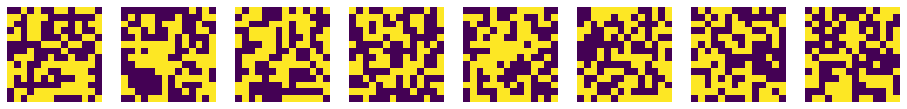

196 0.018016582


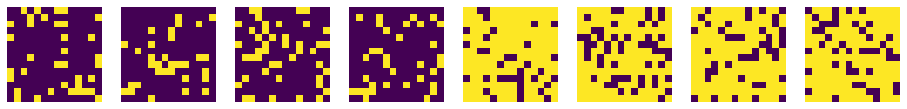

392 0.033003826


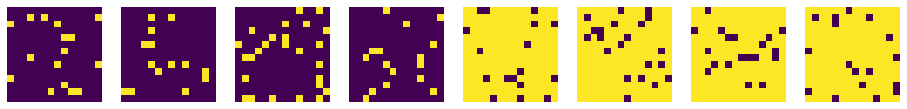

588 0.05321269


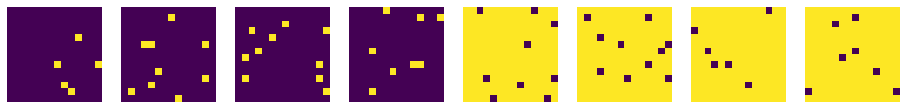

784 0.05189732


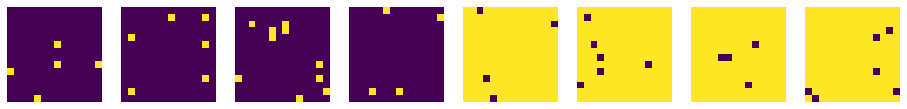

980 0.049944196


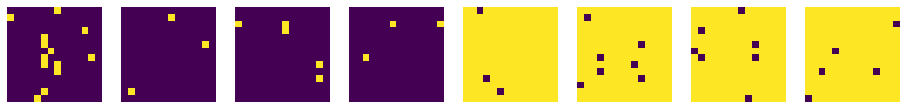

1176 0.057836417


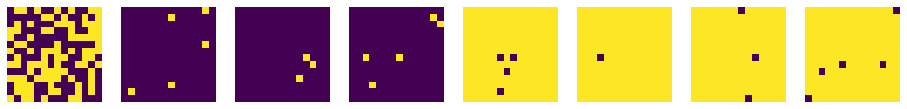

1372 0.07027264


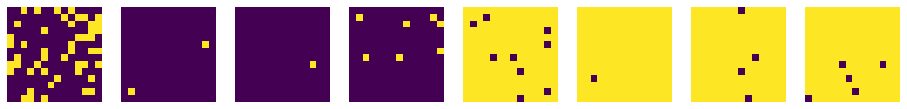

1568 0.07437819


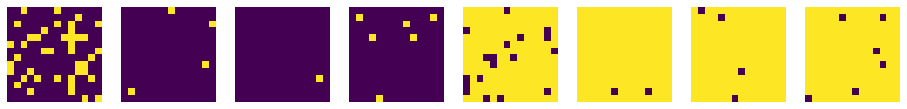

1764 0.08254942


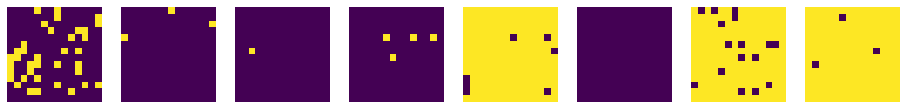

1960 0.07987883


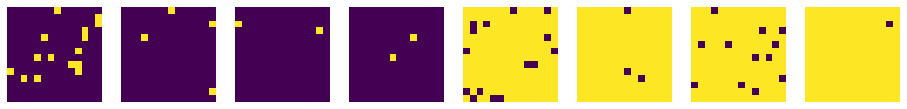

2156 0.0785236


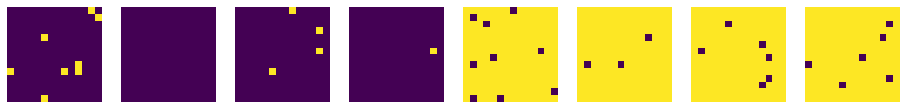

2352 0.07645089


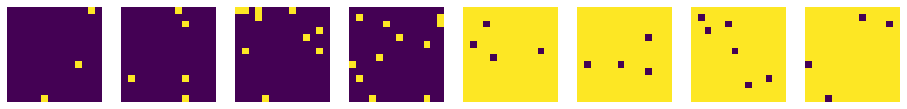

2548 0.082629144


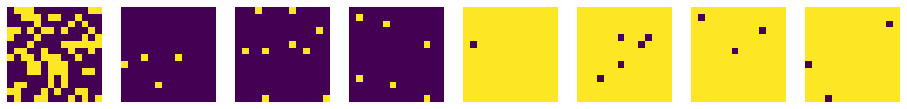

2744 0.07453763


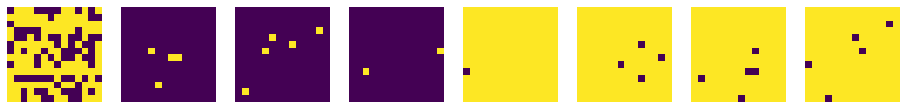

2940 0.0750558


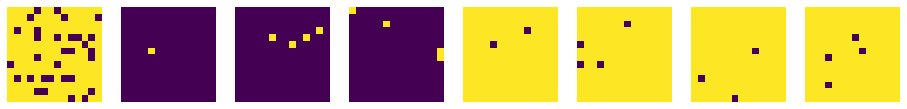

3136 0.07170759


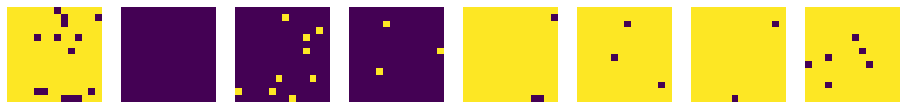

3332 0.07027264


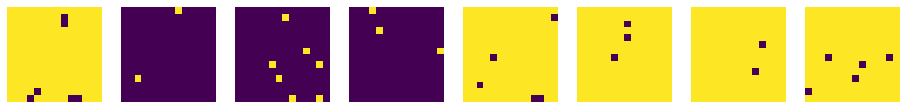

3528 0.05875319


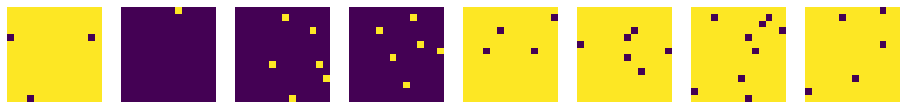

3724 0.056959502


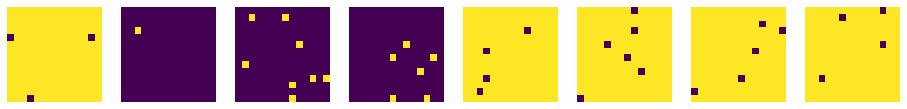

CPU times: user 2min 23s, sys: 16.6 s, total: 2min 39s
Wall time: 1min 6s


In [517]:
%%time

history = []
cfgs = []
nsweep = tf.reduce_prod(x[0].shape)
nsteps = 20*nsweep
print("number of steps in a sweep", nsweep.numpy())
print("number of MC steps in a simulation:", nsteps.numpy())

for i in range(nsteps):
    x = istep(x)
    if i%nsweep == 0:
        print(i, tf.reduce_mean(x).numpy())
        plot_configs(x, 8, plotsize=0.5)
        cfgs.append(x.numpy())
        history.append(tf.reduce_mean(x, axis=(1, 2)).numpy())

history = np.array(history)

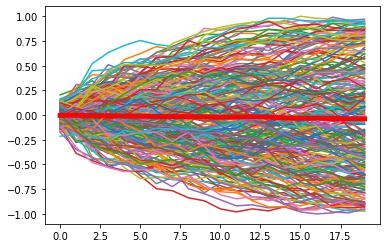

In [488]:
plt.plot(history[:,:])
plt.plot(np.mean(history, axis=1), c='r', lw='5')
plt.show()

### Load data from MC simulations

In [7]:
sim_dir = '../sim/mini'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']        # ferromagnetic
temps.extend(['a100', 'a20', 'a10', 'a5', 'a2', 'a1'])  # antiferromagnetic

In [8]:
trjs = {}
for t in temps:
    #print(t)
    traj = read_lattice_ising(os.path.join(sim_dir, t))
    trjs[t] = Trajectory(traj)
    trjs[t] = trjs[t][1:]

print(trjs.keys())
print(len(trjs['t1']['energy']))

dict_keys(['t1', 't2', 't5', 't10', 't20', 't100', 'a100', 'a20', 'a10', 'a5', 'a2', 'a1'])
1000


In [9]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((15, 15), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

## Examples of configurations for ferromagnetic (t) and antiferromagnetic (a) Ising models at different reduced temperatures (1 - 100)

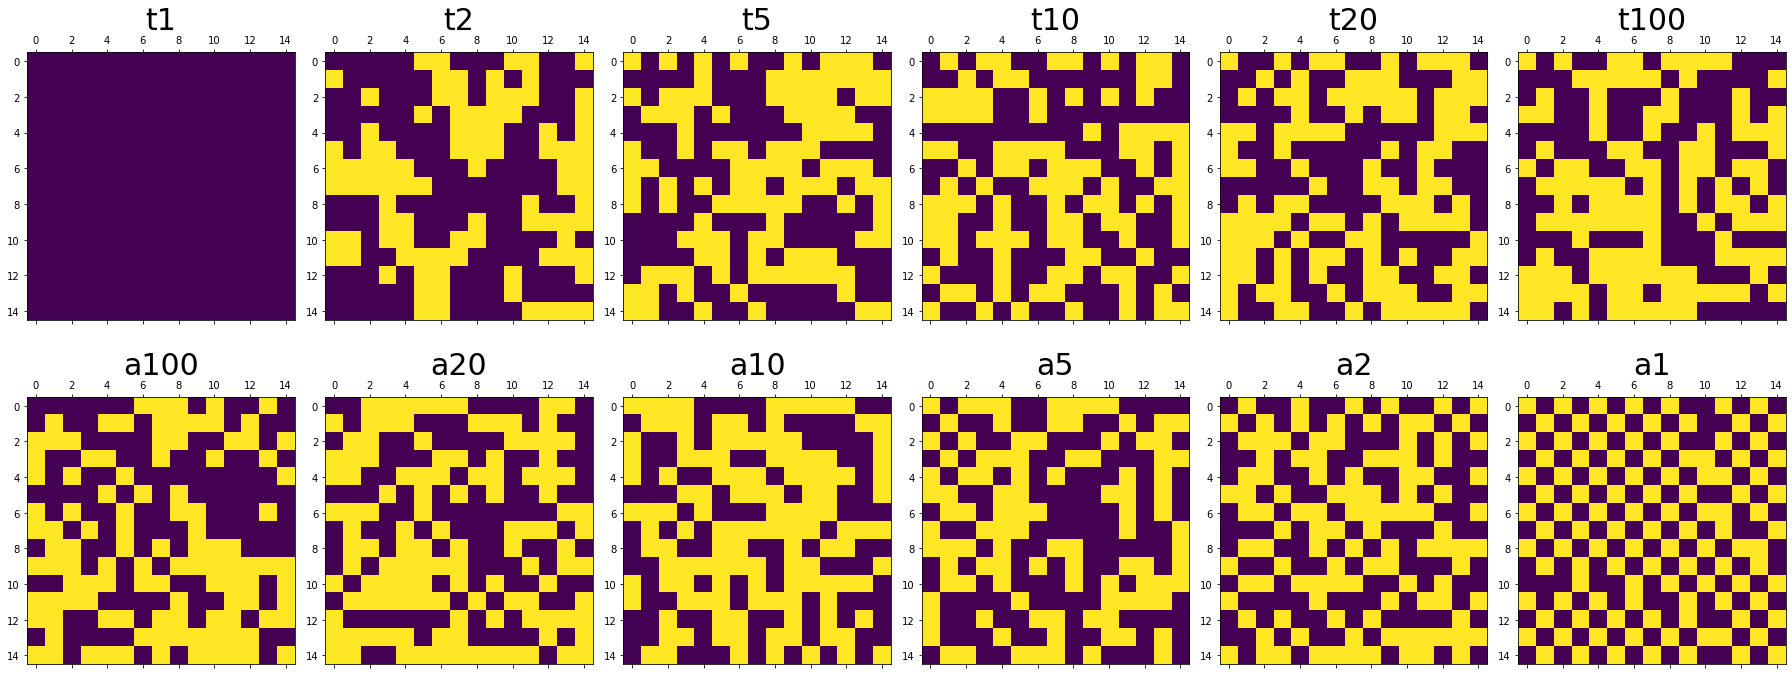

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(25,10))
axs = axs.flatten()
for i, t in enumerate(temps):
    axs[i].set_title(t, fontsize=30)
    axs[i].matshow(cfgs[t][200])

fig.tight_layout()

In [11]:
# Input image dimensions
img_rows, img_cols = cfgs['t1'][0].shape
channels = 1
img_shape = (img_rows, img_cols, channels)

# Dimensions of the embedding space
z_dim = 3

print('Input image shape: ', img_shape)
print('Feature space dimension: ', z_dim)

Input image shape:  (15, 15, 1)
Feature space dimension:  3


## 2. Representation Learning

Discriminate between different Ising systems by embedding each system into a probability space and optimizing classification in this space. Another (better) option is to maximize between-class/within-class variance ratio (as in Fisher/Linear Discriminant Analysis). This would directly optimize statistical distances.

### 2.1 Model definitions

In [26]:
def build_embedding(img_shape, nfilt, ndim, activation='relu'):
    """Model to embed 2D Ising configurations into an ndim-dimensional probability space.
    
    Collect local configurations from 3x3 windows, convert them into n-dimensional features,
    and convert those into a probability vector using average pooling over the whole
    configuration. 
    
    Arguments
    ---------
    img_shape: tuple
        Shape of the input data
    nfilt: int
        Number of filters in the first layer
    ndim: int
        Embedding dimension
    """
    #initializer = tf.keras.initializers.Orthogonal()
    initializer = 'lecun_normal'
    initializer = 'glorot_uniform'

    model = Sequential()
    model.add(Conv2D(nfilt, kernel_size=3, kernel_initializer=initializer, strides=2, padding='valid',
                     input_shape=img_shape))
    model.add(Activation(activation))
    model.add(Conv2D(ndim, kernel_size=1, kernel_initializer=initializer, strides=1, padding='valid'))
    model.add(Softmax())
    # Assuming indpendent local conigurations, create a unit vector for the whole configuration
    model.add(GlobalAveragePooling2D())  
    model.add(Lambda(lambda x: tf.math.sqrt(x)))

    return model

In [27]:
def build_classifier(nclass):
    """Build a simple linear logistic regression classifier on the probability space.
    Setting use_bias=False ensures that the decision boundaries are geodesics on a sphere.
    
    Arguments
    ---------
    nclass: int
        Number of classes
    """

    model = Sequential()
    model.add(Dense(nclass, use_bias=False))
    model.add(Softmax())
    
    return model

In [28]:
def build_discriminator(mdl_embed, mdl_class):
    """Combine embedding and classification modules"""
 
    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_class)
    
    return model

### 2.2 Training data preparation

In [29]:
# Set up training data
data_list = [np.expand_dims(np.array(cfgs[t][:]), axis=-1) for t in temps]#["t1", "t100", "a1"]]

In [30]:
# Flip half of t1 configurations (to compensate for the low probability of switching between configs)
dd = data_list[0]
dd[:500] = 1 - dd[:500]
data_list[0] = dd

In [31]:
data_train = np.concatenate(data_list, axis=0)
data_train.shape

(12000, 15, 15, 1)

In [32]:
# Set up labels
#data_out = np.concatenate([mm(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels = np.concatenate(class_list, axis=0)
labels.shape

(12000,)

In [33]:
# Shuffle data
idx = np.random.permutation(len(labels)) # mix them a bit
data_train = data_train[idx]
labels = labels[idx]
labels_tf = tf.convert_to_tensor(labels, dtype=tf.int32)
data_train.shape, labels_tf.shape

((12000, 15, 15, 1), TensorShape([12000]))

### 2.3 Model building, compiling, and training

**Define loss function for representation learning**

In [34]:
# Build embedding
mdl_embed = build_embedding(img_shape, nfilt=8, ndim=3, activation='relu')

# Build classification layers on top of embedding to train the embedder
mdl_class = build_classifier(nclass=len(np.unique(labels)))

# Connect embedding and classification for representation learning
mdl_train = build_discriminator(mdl_embed, mdl_class)

optimizer = RMSprop()

In [35]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
mdl_train.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
history = mdl_train.fit(data_train, labels_tf, batch_size=60, epochs=1000, verbose=1)

Epoch 1/1000
200/200 [==============================] - 1s 1ms/step - loss: 2.5574 - accuracy: 0.0870
Epoch 2/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.5029 - accuracy: 0.0852
Epoch 3/1000
200/200 [==============================] - 0s 1ms/step - loss: 2.4788 - accuracy: 0.0853
Epoch 4/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4615 - accuracy: 0.1307
Epoch 5/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4374 - accuracy: 0.2727
Epoch 6/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.4101 - accuracy: 0.2379
Epoch 7/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3756 - accuracy: 0.2569
Epoch 8/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3440 - accuracy: 0.2998
Epoch 9/1000
200/200 [==============================] - 0s 2ms/step - loss: 2.3104 - accuracy: 0.2941
Epoch 10/1000
200/200 [==============================] - 0s 1ms/step - loss: 2.276

200/200 [==============================] - 0s 2ms/step - loss: 1.2423 - accuracy: 0.5417
Epoch 160/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2594 - accuracy: 0.5428
Epoch 161/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.2416 - accuracy: 0.5411
Epoch 162/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.2357 - accuracy: 0.5492
Epoch 163/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2444 - accuracy: 0.5358
Epoch 164/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.2582 - accuracy: 0.5347
Epoch 165/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2467 - accuracy: 0.5457
Epoch 166/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.2394 - accuracy: 0.5518
Epoch 167/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.2481 - accuracy: 0.5376
Epoch 168/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 1ms/step - loss: 1.1499 - accuracy: 0.5513
Epoch 316/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1512 - accuracy: 0.5551
Epoch 317/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1625 - accuracy: 0.5520
Epoch 318/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1543 - accuracy: 0.5545
Epoch 319/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1624 - accuracy: 0.5491
Epoch 320/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1438 - accuracy: 0.5550
Epoch 321/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1684 - accuracy: 0.5493
Epoch 322/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1509 - accuracy: 0.5505
Epoch 323/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1554 - accuracy: 0.5524
Epoch 324/1000
200/200 [==============================] - 0s 1ms/step - loss: 1

200/200 [==============================] - 0s 1ms/step - loss: 1.1272 - accuracy: 0.5532
Epoch 472/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1259 - accuracy: 0.5528
Epoch 473/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1276 - accuracy: 0.5570
Epoch 474/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1311 - accuracy: 0.5469
Epoch 475/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1261 - accuracy: 0.5533
Epoch 476/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1276 - accuracy: 0.5528
Epoch 477/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1233 - accuracy: 0.5569
Epoch 478/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1347 - accuracy: 0.5451
Epoch 479/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1213 - accuracy: 0.5494
Epoch 480/1000
200/200 [==============================] - 0s 1ms/step - loss: 1

200/200 [==============================] - 0s 2ms/step - loss: 1.1051 - accuracy: 0.5619
Epoch 628/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1117 - accuracy: 0.5576
Epoch 629/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.1190 - accuracy: 0.5446
Epoch 630/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0947 - accuracy: 0.5591
Epoch 631/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.1094 - accuracy: 0.5545
Epoch 632/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1008 - accuracy: 0.5625
Epoch 633/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0986 - accuracy: 0.5585
Epoch 634/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0983 - accuracy: 0.5624
Epoch 635/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.1133 - accuracy: 0.5516
Epoch 636/1000
200/200 [==============================] - 0s 1ms/step - loss: 1

200/200 [==============================] - 1s 4ms/step - loss: 1.0894 - accuracy: 0.5658
Epoch 784/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0799 - accuracy: 0.5687
Epoch 785/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0801 - accuracy: 0.5626
Epoch 786/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0961 - accuracy: 0.5541
Epoch 787/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0987 - accuracy: 0.5581
Epoch 788/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0853 - accuracy: 0.5631
Epoch 789/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0870 - accuracy: 0.5649
Epoch 790/1000
200/200 [==============================] - 1s 3ms/step - loss: 1.0824 - accuracy: 0.5607
Epoch 791/1000
200/200 [==============================] - 1s 4ms/step - loss: 1.0717 - accuracy: 0.5692
Epoch 792/1000
200/200 [==============================] - 0s 2ms/step - loss: 1

200/200 [==============================] - 0s 1ms/step - loss: 1.0830 - accuracy: 0.5572
Epoch 940/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0844 - accuracy: 0.5574
Epoch 941/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0862 - accuracy: 0.5592
Epoch 942/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0791 - accuracy: 0.5583
Epoch 943/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0889 - accuracy: 0.5550
Epoch 944/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0767 - accuracy: 0.5588
Epoch 945/1000
200/200 [==============================] - 0s 1ms/step - loss: 1.0820 - accuracy: 0.5513
Epoch 946/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0805 - accuracy: 0.5568
Epoch 947/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.0846 - accuracy: 0.5578
Epoch 948/1000
200/200 [==============================] - 0s 1ms/step - loss: 1

### 2.4 Model performance

Text(0.5, 0.98, 'Optimization History')

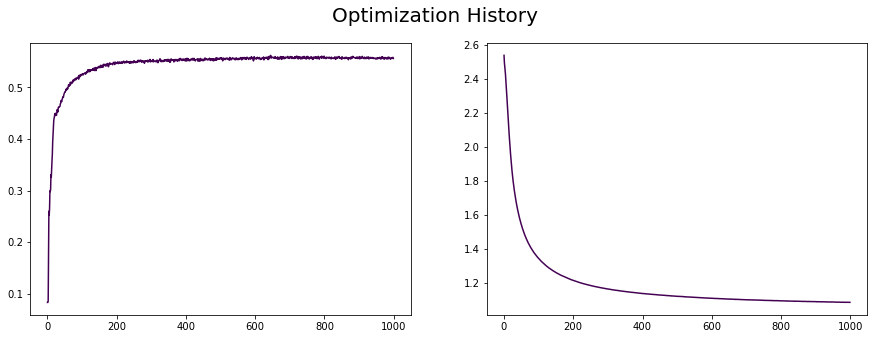

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['accuracy'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [37]:
# Set up training data and lables
data_out = np.concatenate([mdl_embed(dat) for dat in data_list], axis=0)
class_list = [np.array(len(cfg)*[i]) for i, cfg in enumerate(data_list)]
labels_out = np.concatenate(class_list, axis=0)
data_out.shape, labels_out.shape

((12000, 3), (12000,))

In [38]:
if data_out.shape[1] == 2:
    do = data_out[:,0]**2
    dd = np.vstack([do, labels_out]).T
    for c in np.unique(labels_out):
        indx = np.where(dd[:, 1] == c)
        print(np.mean(dd[indx, 0]))

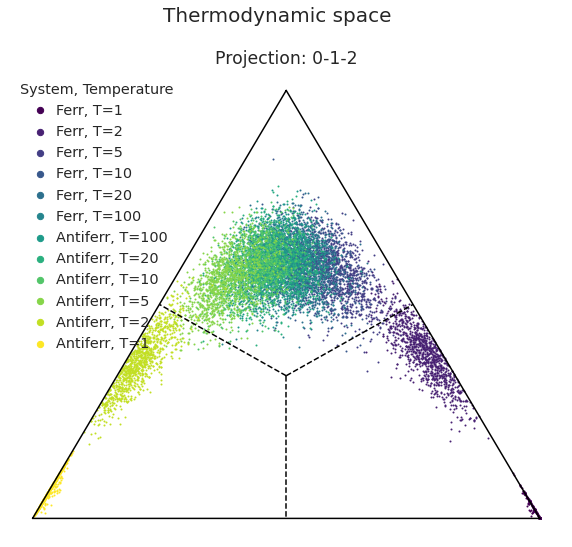

In [39]:
trslt = {'t':'Ferr', 'a':"Antiferr"}
cnames = [f'{trslt[t[0]]}, T={t[1:]}' for t in temps]
plot_ternary(data_out[idx]**2, labels_out[idx], np.unique(labels_out), class_names = cnames, plt_title = "Thermodynamic space",
             size=10)

<IPython.core.display.Javascript object>


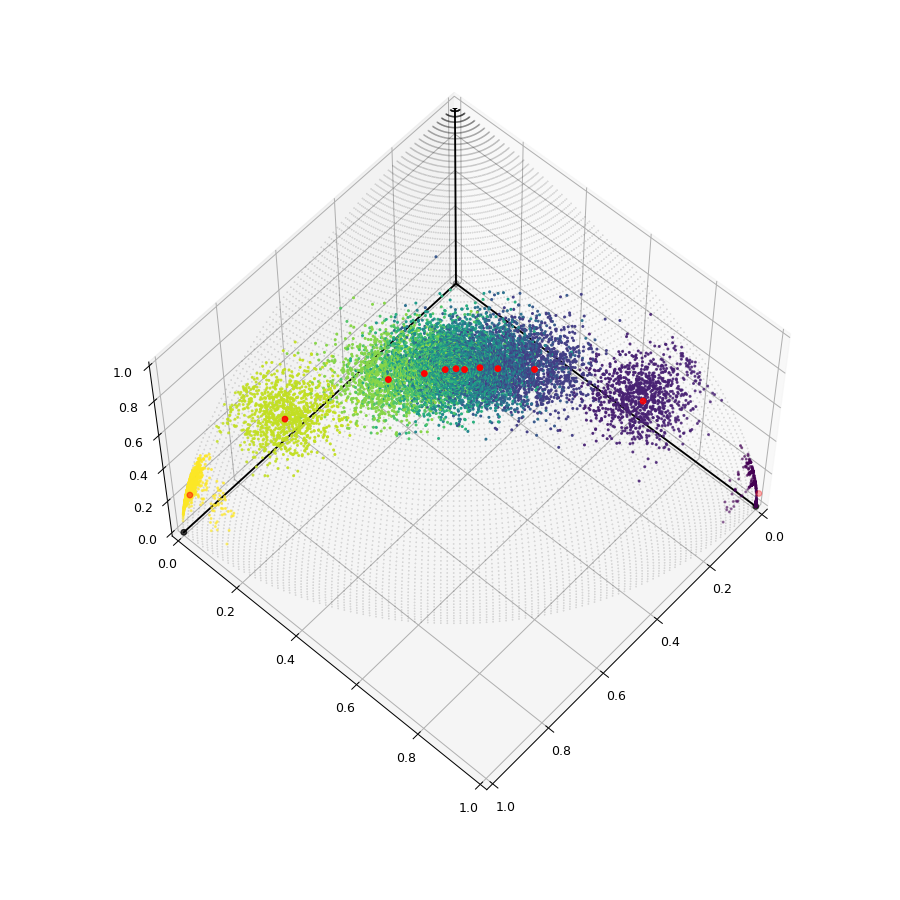

In [40]:
%matplotlib notebook
plot_spherical(data_out, labels_out)

<IPython.core.display.Javascript object>


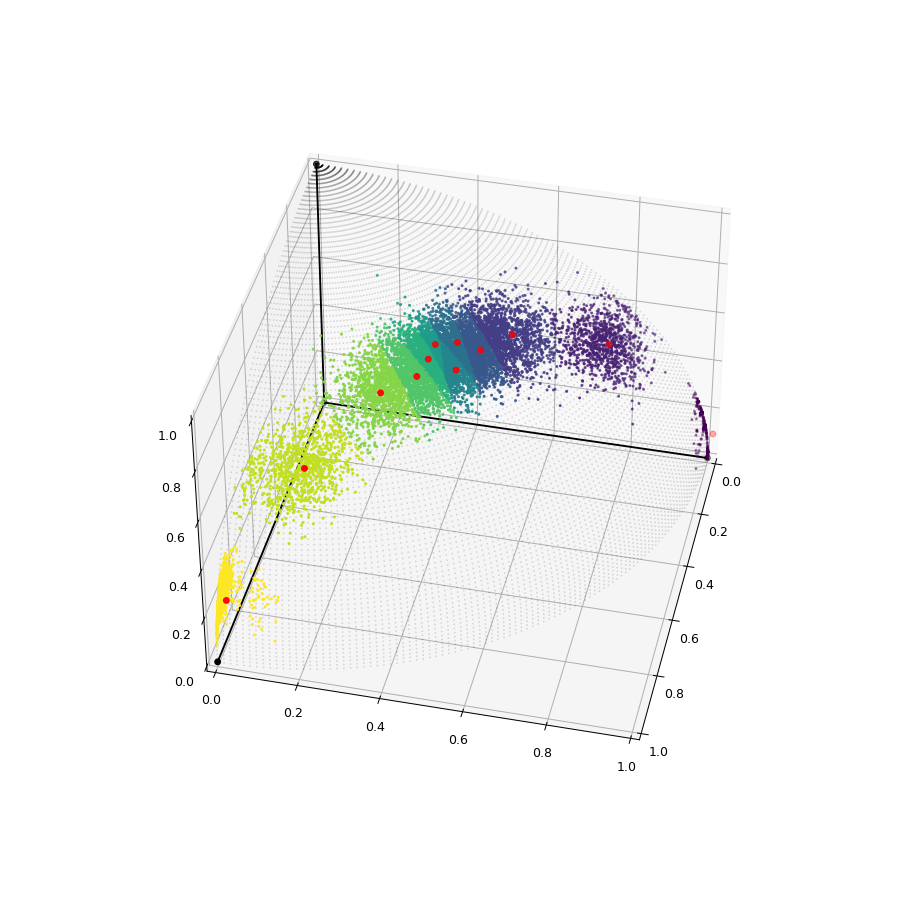

In [41]:
# Predict classes
labels_pred = np.argmax(mdl_train.predict(data_train), axis=1)
#plot_ternary(data_out[idx]**2, labels_pred, np.unique(labels_pred), class_names = cnames, plt_title = "Thermodynamic space",
#             size=10)
plot_spherical(data_out[idx], labels_pred)

<IPython.core.display.Javascript object>


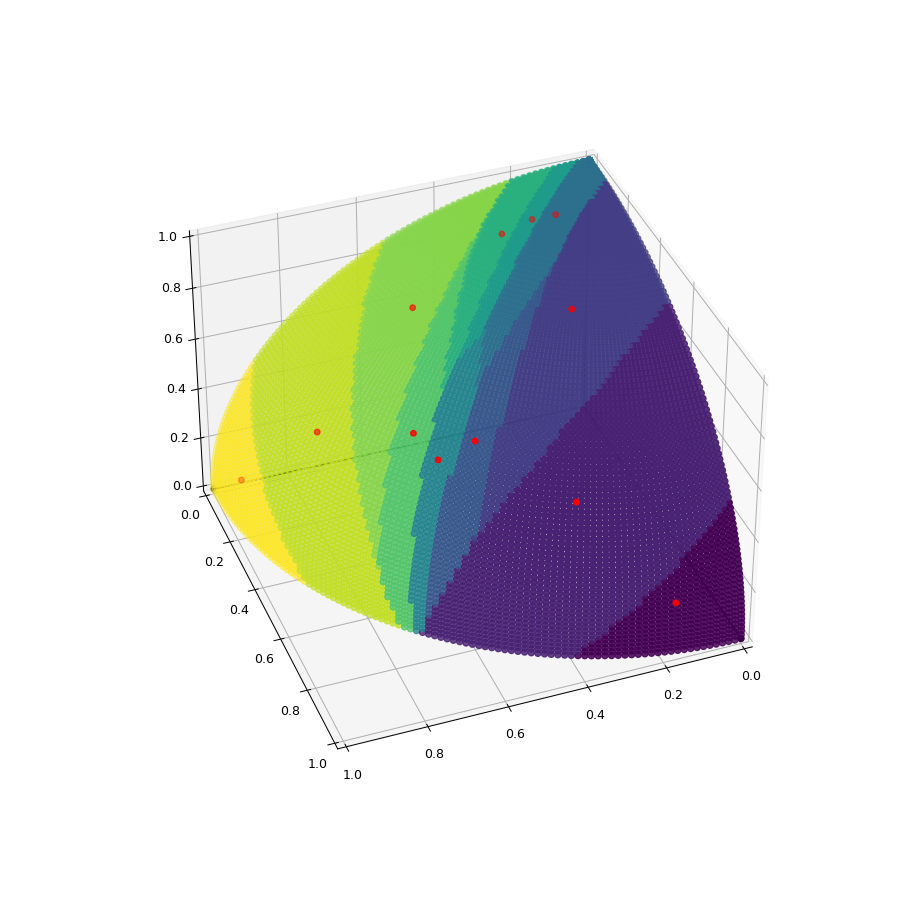

In [42]:
def get_sphere_points():
    phi, theta = np.mgrid[0.0:np.pi/2:100j, 0.0:np.pi/2:100j]
    x = np.sin(phi)*np.cos(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(phi)
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    data = np.vstack([x, y, z]).T
    return data

points_in = get_sphere_points()
points_pred = np.argmax(mdl_class(points_in), axis=1)
plot_spherical(points_in, points_pred, psize=25)

In [43]:
%matplotlib inline

**Calculate maximum likelihood estimates of multinomial distributions for each class**

In [44]:
out = get_estimates(data_out, labels_out, epochs=1000)

## 3. Learning and Predicting System Properties

Learn mapping between the trained embedding (thermodynamic) space and physical properties

### 3.1 System temperature

#### 3.1.1 Model and its training

In [45]:
def build_temp_prob(nunit):
    """Determine the probability distribution of temperature.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature distribution.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))  # from <0, 1> to real
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(tfp.layers.DistributionLambda(
        lambda t: tfd.LogNormal(loc=t[..., :1], scale=tf.math.exp(t[..., 1:]))
    ))
    
    return model

In [46]:
def build_temp_layers(nunit):
    """Determine temperature of the system generating given configurations.
    
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))  # from <0, 1> to real
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(nunit))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Lambda(lambda x: tf.math.exp(x)))  # from real to <0, Inf>
    
    return model

In [47]:
def build_property_learn(mdl_embed, mdl_prop):
 
    mdl_embed.trainable = False

    # Build a complete model
    model = Sequential()
    model.add(mdl_embed)
    model.add(mdl_prop)

    return model

In [48]:
mdl_temp_layers = build_temp_prob(6)
mdl_temp = build_property_learn(mdl_embed, mdl_temp_layers)

In [49]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [50]:
mdl_temp.compile(loss=negloglik, optimizer=Adam())

In [51]:
#mdl_temp.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['MAE'], optimizer=Adam())

In [52]:
temp_list = [np.array(len(cfg)*[1/float(t[1:])]) for t, cfg in zip(temps, data_list)]
y_temp = np.concatenate(temp_list, axis=0)
y_temp.shape
y_temp = y_temp[idx]

In [53]:
history = mdl_temp.fit(data_train, y_temp, batch_size=240, epochs=200, verbose=1)

Epoch 1/200
50/50 [==============================] - 0s 1ms/step - loss: 2.9524
Epoch 2/200
50/50 [==============================] - 0s 1ms/step - loss: 0.9220
Epoch 3/200
50/50 [==============================] - 0s 1ms/step - loss: 0.1089
Epoch 4/200
50/50 [==============================] - 0s 1ms/step - loss: -0.0466
Epoch 5/200
50/50 [==============================] - 0s 1ms/step - loss: -0.1485
Epoch 6/200
50/50 [==============================] - 0s 1ms/step - loss: -0.2468
Epoch 7/200
50/50 [==============================] - 0s 1ms/step - loss: -0.3144
Epoch 8/200
50/50 [==============================] - 0s 1ms/step - loss: -0.3643
Epoch 9/200
50/50 [==============================] - 0s 1ms/step - loss: -0.4385
Epoch 10/200
50/50 [==============================] - 0s 1ms/step - loss: -0.4947
Epoch 11/200
50/50 [==============================] - 0s 1ms/step - loss: -0.5550
Epoch 12/200
50/50 [==============================] - 0s 1ms/step - loss: -0.6052
Epoch 13/200
50/50 [========

50/50 [==============================] - 0s 1ms/step - loss: -1.3547
Epoch 102/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4015
Epoch 103/200
50/50 [==============================] - 0s 1ms/step - loss: -1.3789
Epoch 104/200
50/50 [==============================] - 0s 1ms/step - loss: -1.3880
Epoch 105/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4018
Epoch 106/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4054
Epoch 107/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4035
Epoch 108/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4080
Epoch 109/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4012
Epoch 110/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4130
Epoch 111/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4121
Epoch 112/200
50/50 [==============================] - 0s 1ms/step - loss: -1.4096
Epoch 113/200
50/5

#### 3.1.2 Evaluation and predictions

Text(0.5, 0.98, 'Optimization History')

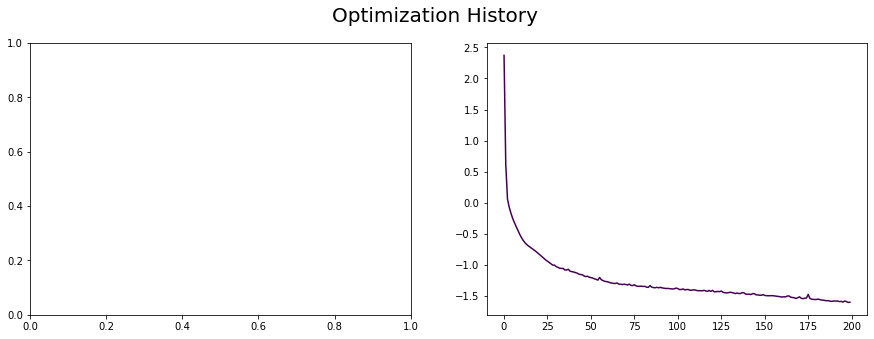

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#axs[0].plot(history.history['MAE'])
axs[1].plot(history.history['loss'])
fig.suptitle("Optimization History", fontsize=20)

In [55]:
y_pred = mdl_temp.predict(data_train)

In [56]:
y_pred

array([[0.00813258],
       [0.03809593],
       [0.5031402 ],
       ...,
       [0.9544039 ],
       [0.03754025],
       [0.0621021 ]], dtype=float32)

In [57]:
t_dist = mdl_temp(data_train)

In [58]:
t_dist.mean()

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[0.07483216],
       [0.13501628],
       [0.50147337],
       ...,
       [0.9949831 ],
       [0.09271833],
       [0.12122737]], dtype=float32)>

In [59]:
t_dist.stddev()

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[0.13171257],
       [0.10729527],
       [0.03519981],
       ...,
       [0.02481487],
       [0.16848782],
       [0.16138607]], dtype=float32)>

In [60]:
t_dist

<tfp.distributions.LogNormal 'sequential_7_sequential_6_distribution_lambda_LogNormal' batch_shape=[12000, 1] event_shape=[] dtype=float32>

In [61]:
t_dist.sample()

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[0.2605025 ],
       [0.08892214],
       [0.506817  ],
       ...,
       [0.94649106],
       [0.01952606],
       [0.15226603]], dtype=float32)>

(0.0, 1.5)

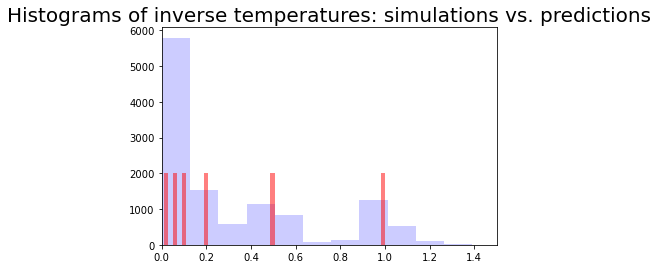

In [62]:
%matplotlib inline
_ = plt.hist(np.ravel(y_pred), color='b', alpha=0.2, bins=50, label="Predicted")
#_ = plt.hist(np.ravel(t_dist.mean()), color='g', alpha=0.5, bins=500, label="Predicted")
_ = plt.hist(np.ravel(y_temp), color='r', alpha=0.5, bins=50, label="Simulated")
plt.title("Histograms of inverse temperatures: simulations vs. predictions", fontsize=20)
plt.xlim(0, 1.5)

Text(0.5, 1.0, 'Predicted vs. simulated inverse temperature')

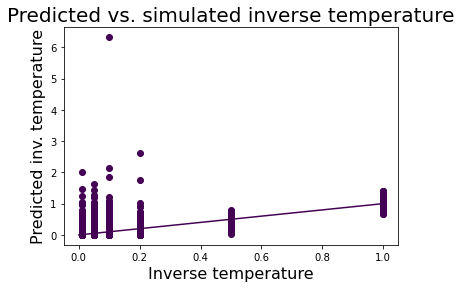

In [63]:
plt.scatter(np.ravel(y_temp), np.ravel(y_pred))
plt.plot([0, 1], [0, 1])
plt.xlabel("Inverse temperature", fontsize=16)
plt.ylabel("Predicted inv. temperature", fontsize=16)
plt.title("Predicted vs. simulated inverse temperature", fontsize=20)

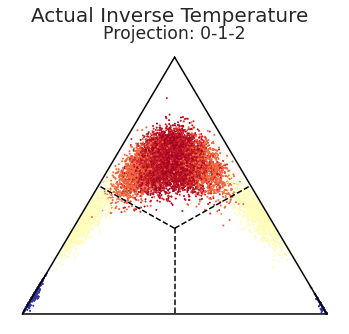

In [64]:
plot_ternary_continuum(data_out[idx]**2, np.ravel(y_temp), size=6, plt_title = "Actual Inverse Temperature")

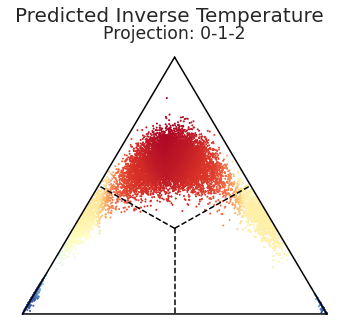

In [65]:
plot_ternary_continuum(data_out[idx]**2, np.ravel(t_dist.mean()), size=6, plt_title = "Predicted Inverse Temperature")

### 3.2 System type: Ferromagnetic vs. Antiferromagnetic

#### 3.2.1 Model and its training

In [66]:
def build_system_id_layers(ndim):
    """Classify configurations as coming from ferromagnetic or antiferromagnetic systems
        
    Note that the effect of temperature is indistinguishable from the overall interaction strength.
    
    Arguments:
    ----------
    ndim: int
        dimension of the input embedding space 
        
    Returns:
    --------
    model: tensorflow model
        Model translating a vector in the thermodynamic space into temperature.
    """
       
    model = Sequential()
    model.add(Lambda(lambda x: tf.math.log(x)))
    model.add(Dense(ndim))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [67]:
mdl_sysid_layers = build_system_id_layers(ndim = 4)
mdl_sysid = build_property_learn(mdl_embed, mdl_sysid_layers)

In [68]:
mdl_sysid.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], optimizer=Adam())

In [69]:
sysid_list = [np.array(len(cfg)*[int(t[0] == "a")]) for t, cfg in zip(temps, data_list)]
y_sysid = np.concatenate(sysid_list, axis=0)
y_sysid = np.expand_dims(y_sysid, axis=-1)
y_sysid.shape
y_sysid = y_sysid[idx]

In [70]:
history = mdl_sysid.fit(data_train, y_sysid, epochs=100, verbose=1)

Epoch 1/100
375/375 [==============================] - 1s 1ms/step - loss: 0.8316 - accuracy: 0.3264
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 0.5669 - accuracy: 0.7748
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.4655 - accuracy: 0.8505
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.3990 - accuracy: 0.8563
Epoch 5/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3584 - accuracy: 0.8539
Epoch 6/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3349 - accuracy: 0.8552
Epoch 7/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3221 - accuracy: 0.8555
Epoch 8/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3123 - accuracy: 0.8546
Epoch 9/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3037 - accuracy: 0.8547
Epoch 10/100
375/375 [==============================] - 0s 1ms/step - loss: 0.3047 - accura

#### 3.2.2 Evaluation and predictions

In [71]:
# Predict categories: ferromagnetic vs. non-ferromagnetic
y_pred = (np.ravel(mdl_sysid.predict(data_train)) > 0.5).astype(np.int)

idx.shape
print("Confusion matrix")
confusion_matrix(np.ravel(y_sysid), np.ravel(y_pred))

Confusion matrix


<ipython-input-71-a8706cce2fbf>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (np.ravel(mdl_sysid.predict(data_train)) > 0.5).astype(np.int)


array([[5120,  880],
       [ 855, 5145]])

In [72]:
#idx = np.random.permutation(len(correct))  # mix them a bit
correct = (np.ravel(y_sysid) != np.ravel(y_pred)).astype(np.int)

<ipython-input-72-1ff1d779bdb7>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  correct = (np.ravel(y_sysid) != np.ravel(y_pred)).astype(np.int)


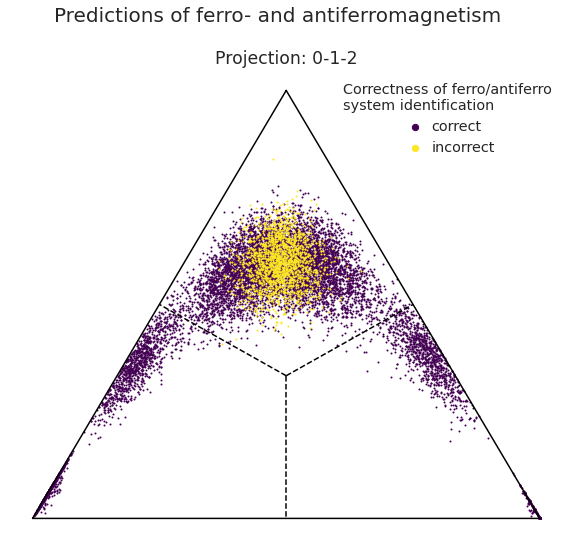

In [73]:
#idx = np.random.permutation(len(correct))  # mix them a bit
plot_ternary(data_out[idx]**2, correct, np.unique(correct), class_names = ["correct", "incorrect"],
             size=10, plt_title = "Predictions of ferro- and antiferromagnetism",
             legend_title = "Correctness of ferro/antiferro\nsystem identification")

## 4. Visualize filters and activations

## Visualize activations

In [74]:
mdl = build_activation_model(mdl_embed)

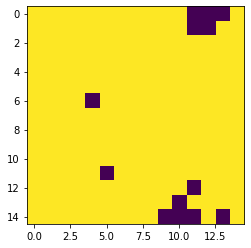

In [75]:
img = cfgs['t1'][60][np.newaxis, :, :, np.newaxis]
plt.imshow(img[0,:,:,0])

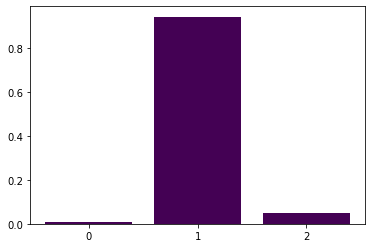

In [76]:
show_probs(img, mdl)

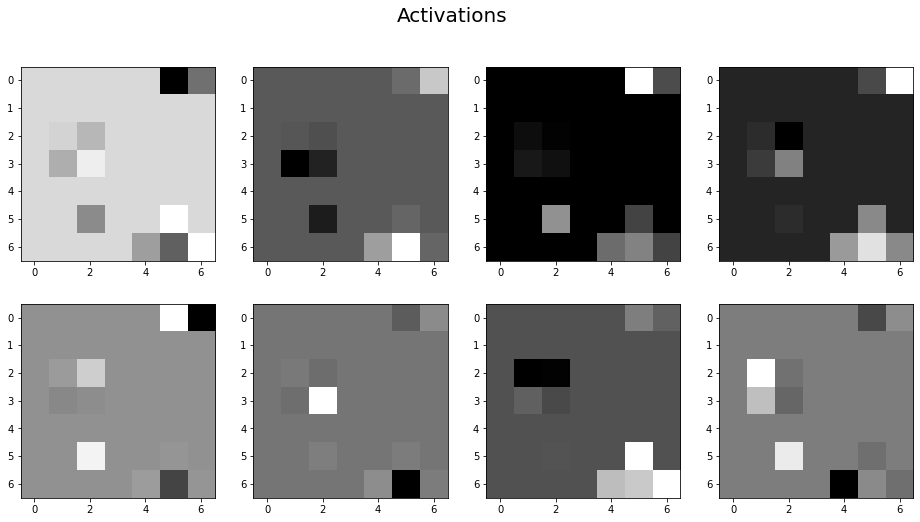

In [77]:
show_activations(img, mdl, layer_num=0, size=4)

### Visualize filters maximizing activation at different layers

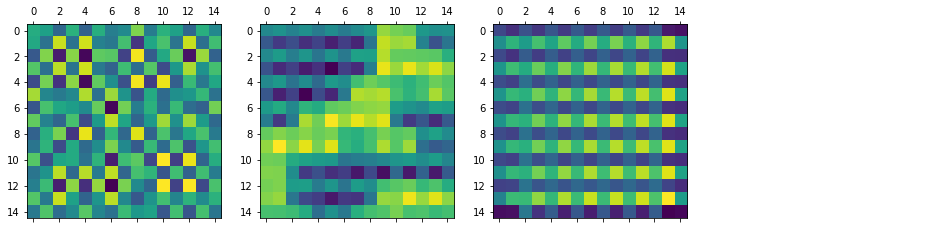

In [78]:
layer_number = 2
feature_extractor = build_feature_extractor(mdl_embed, layer_number=layer_number)
show_filters(nfilt=3, cfg_shape=data_train[0:1].shape, feature_extractor=feature_extractor)
#feature_extractor.summary()